In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler


## Preparing data (logarithmic transformation of explainable variable, division into training and test data set)

In [2]:
# Loading data and data processing
df_train = pd.read_csv("MEPS_data_preprocessed_train.csv")
df_test = pd.read_csv("MEPS_data_preprocessed_test.csv")

# droping columns
df_train.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)
df_test.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)


# Logarithmic transforamtion of healthexpenses
val_train = df_train['HEALTHEXP'].values
df_train['HEALTHEXP'] = np.array([0 if v == 0 else np.log(v) / np.log(3) for v in val_train])
val_test = df_test['HEALTHEXP'].values
df_test['HEALTHEXP'] = np.array([0 if v == 0 else np.log(v) / np.log(3) for v in val_test])


In [3]:
x_train = df_train.drop(["HEALTHEXP"], axis = 1)
y_train = df_train["HEALTHEXP"]
x_test = df_test.drop(["HEALTHEXP"], axis = 1)
y_test = df_test["HEALTHEXP"]

## Scoring function and function to plot permutational variable importance

In [4]:
# Function to score model (r^2, rmse, mae)
def get_model_results(model_name: str, pred_train, y_train, pred_test, y_test, print_res):
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    r_2_train = r2_score(y_train, pred_train)
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    r_2_test = r2_score(y_test, pred_test)
    mae_test = mean_absolute_error(y_test, pred_test)
    mae_train = mean_absolute_error(y_train, pred_train)

    if print_res:
        print(f"{model_name} results:")
        print(f"training rmse: {rmse_train}\ntraining r2: {r_2_train}\ntraining mae: {mae_train}")
        print(f"test rmse: {rmse_test}\ntest r2: {r_2_test}\ntest mae: {mae_test}\n")

    return [rmse_train, rmse_test,  r_2_train, r_2_test,  mae_train,  mae_test]

In [5]:
# Function to plot model's  permutational variable importance
def plot_model_permutation_feature_importance(model, X_test, Y_test, model_name: str):
    result = permutation_importance(model, X_test, Y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=(20,25))
    ax.boxplot(result.importances[sorted_idx].T,
               vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title(f"Permutation Importances (test set) for {model_name}")
    fig.tight_layout()
    plt.show()



# 1) Model XGB 

In [6]:
d = 6
n = 60
feature_names = list(x_train)
xgb_reg_1 = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.4,
                          learning_rate = 0.2,
                          max_depth = d,
                          alpha = 15,
                          n_estimators = n,
                          feature_names=feature_names
                          )
xgb_reg_1.fit(x_train, y_train)
predictions_train = xgb_reg_1.predict(x_train)
predictions_test = xgb_reg_1.predict(x_test)
xgb_1_res = get_model_results(f"XGB  ", predictions_train, y_train, predictions_test, y_test, True)

XGB   results:
training rmse: 1.9896428769333043
training r2: 0.480823263320056
training mae: 1.4731932200056865
test rmse: 2.1815080002619207
test r2: 0.36767723504652927
test mae: 1.6220293519004516



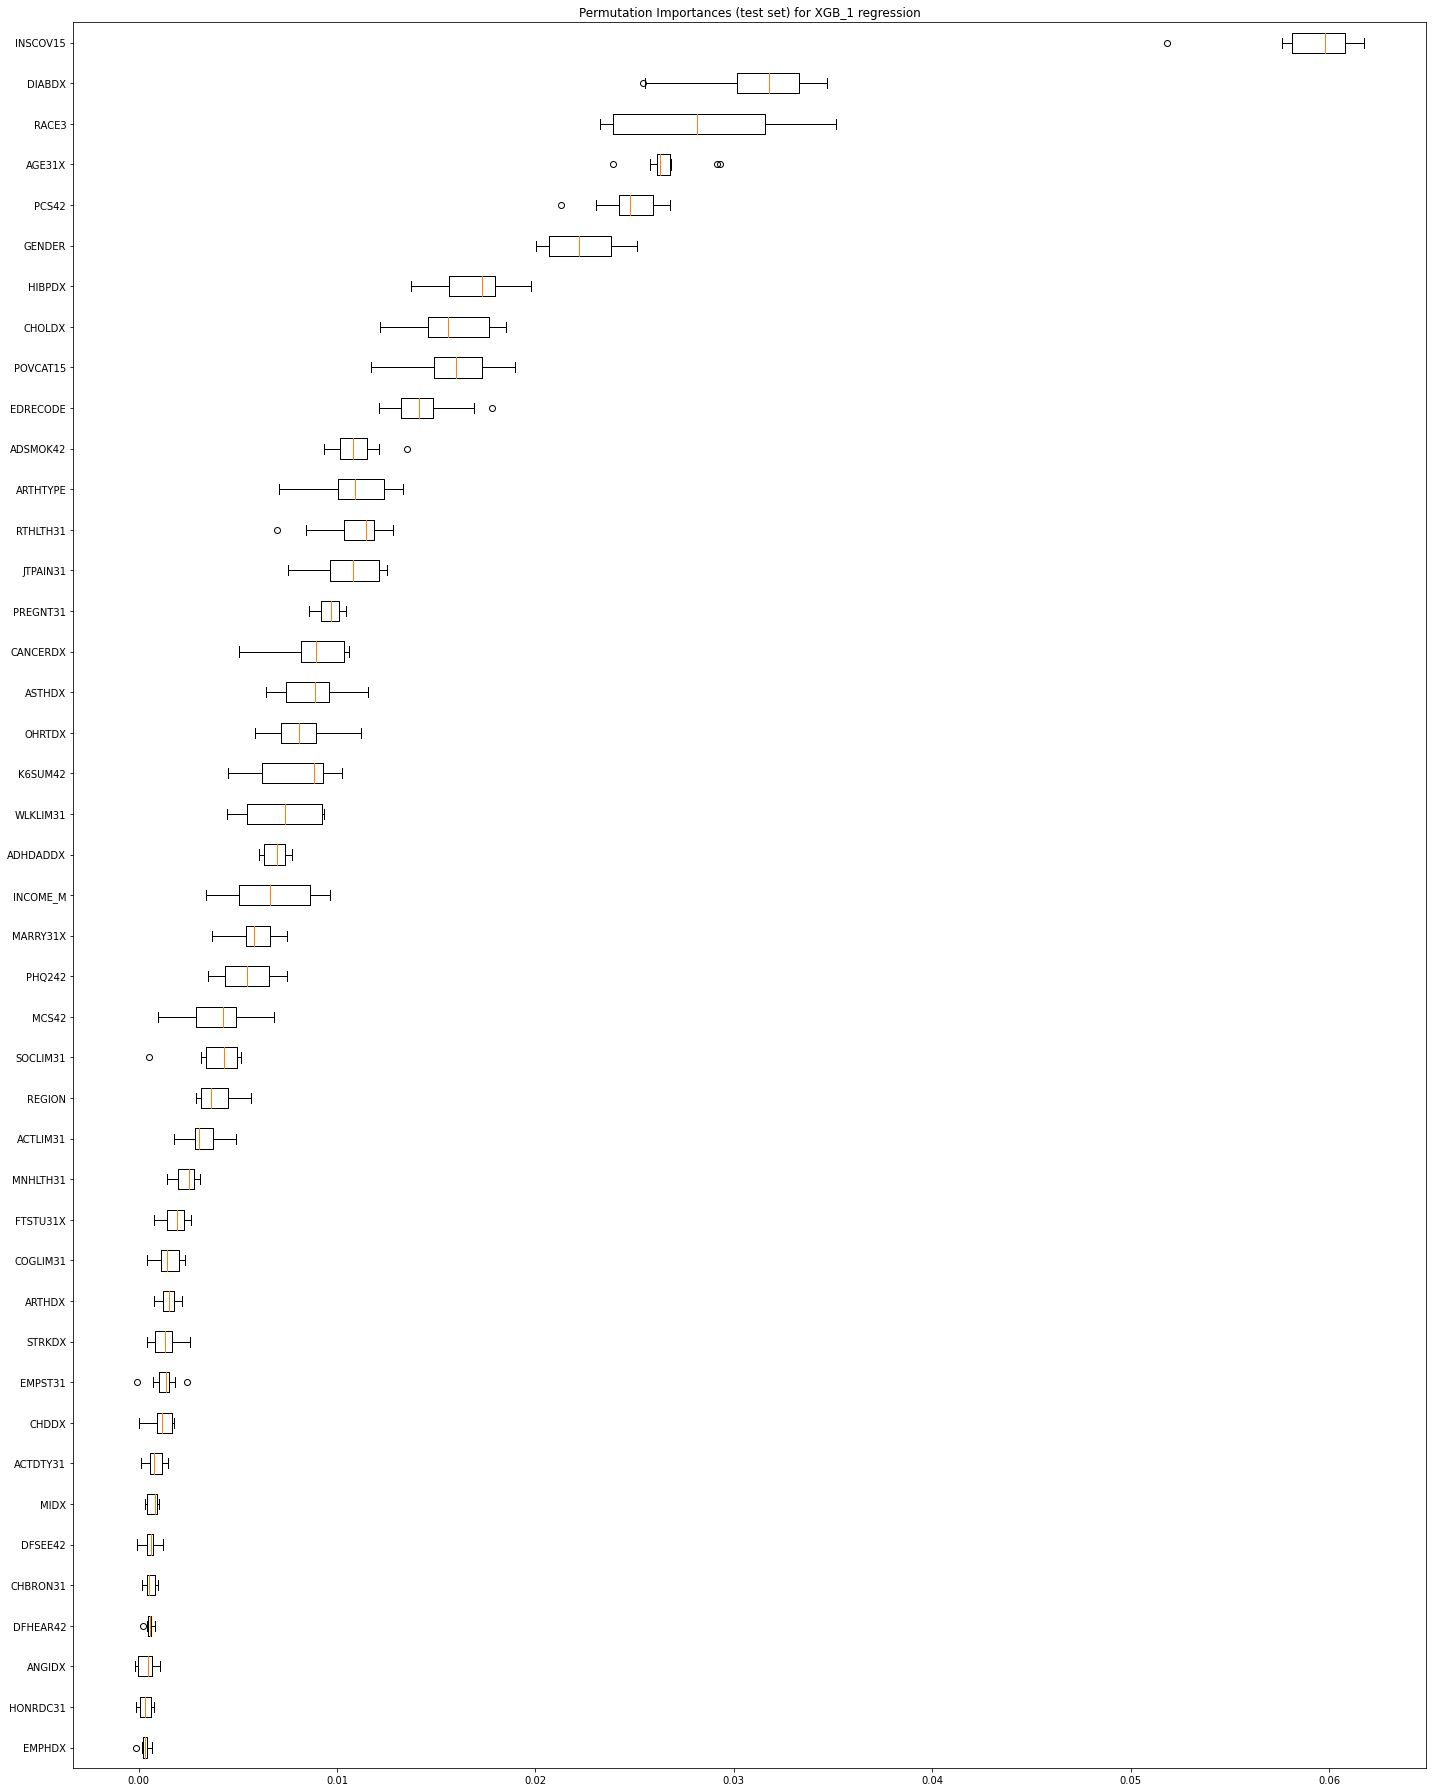

In [7]:
plot_model_permutation_feature_importance(xgb_reg_1, x_test, y_test, "XGB_1 regression")

## 2) Model XGB with additional data transformations
### Model's additional data transformations: one hot encoding, minmax scaling

In [23]:
x_train_2 = x_train.copy()
x_test_2 = x_test.copy()

# Minmax scaling
inx_to_minmax_scale = ['RTHLTH31', 'MNHLTH31', 'POVCAT15'] 

scaler = MinMaxScaler()

for col in inx_to_minmax_scale:
    val = x_train_2[col].values 
    x_train_2[col] = scaler.fit_transform(val.reshape(-1,1)) 
    val = x_test_2[col].values 
    x_test_2[col] = scaler.fit_transform(val.reshape(-1,1)) 
    
# One hot encoding
cat_inx = x_train_2.nunique()[x_train_2.nunique() == 3 ].index.tolist() # only vairables with values {-1, 1, 2} which means "inapplicable, yes, no"   
cat_inx.remove('INSCOV15')
print(f"Categorical variables to one hot encode:\n {cat_inx}")
x_train_2 = pd.get_dummies(x_train_2, columns=cat_inx)
x_test_2 = pd.get_dummies(x_test_2, columns=cat_inx)

Categorical variables to one hot encode:
 ['HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON31', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN31', 'ARTHDX', 'ASTHDX', 'ADHDADDX', 'PREGNT31', 'WLKLIM31', 'ACTLIM31', 'SOCLIM31', 'COGLIM31', 'DFHEAR42', 'DFSEE42', 'ADSMOK42']


In [9]:
d = 6
n = 60
feature_names = list(x_train)
xgb_reg_2 = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.4,
                          learning_rate = 0.2,
                          max_depth = d,
                          alpha = 15,
                          n_estimators = n,
                          feature_names=feature_names
                          )
xgb_reg_2.fit(x_train_2, y_train)
predictions_train = xgb_reg_2.predict(x_train_2)
predictions_test = xgb_reg_2.predict(x_test_2)
xgb_2_res = get_model_results(f"XGB  ", predictions_train, y_train, predictions_test, y_test, True)

XGB   results:
training rmse: 2.004730414294387
training r2: 0.4729195356270913
training mae: 1.4850506374315113
test rmse: 2.166275261786406
test r2: 0.3764769999538592
test mae: 1.6102627248009824



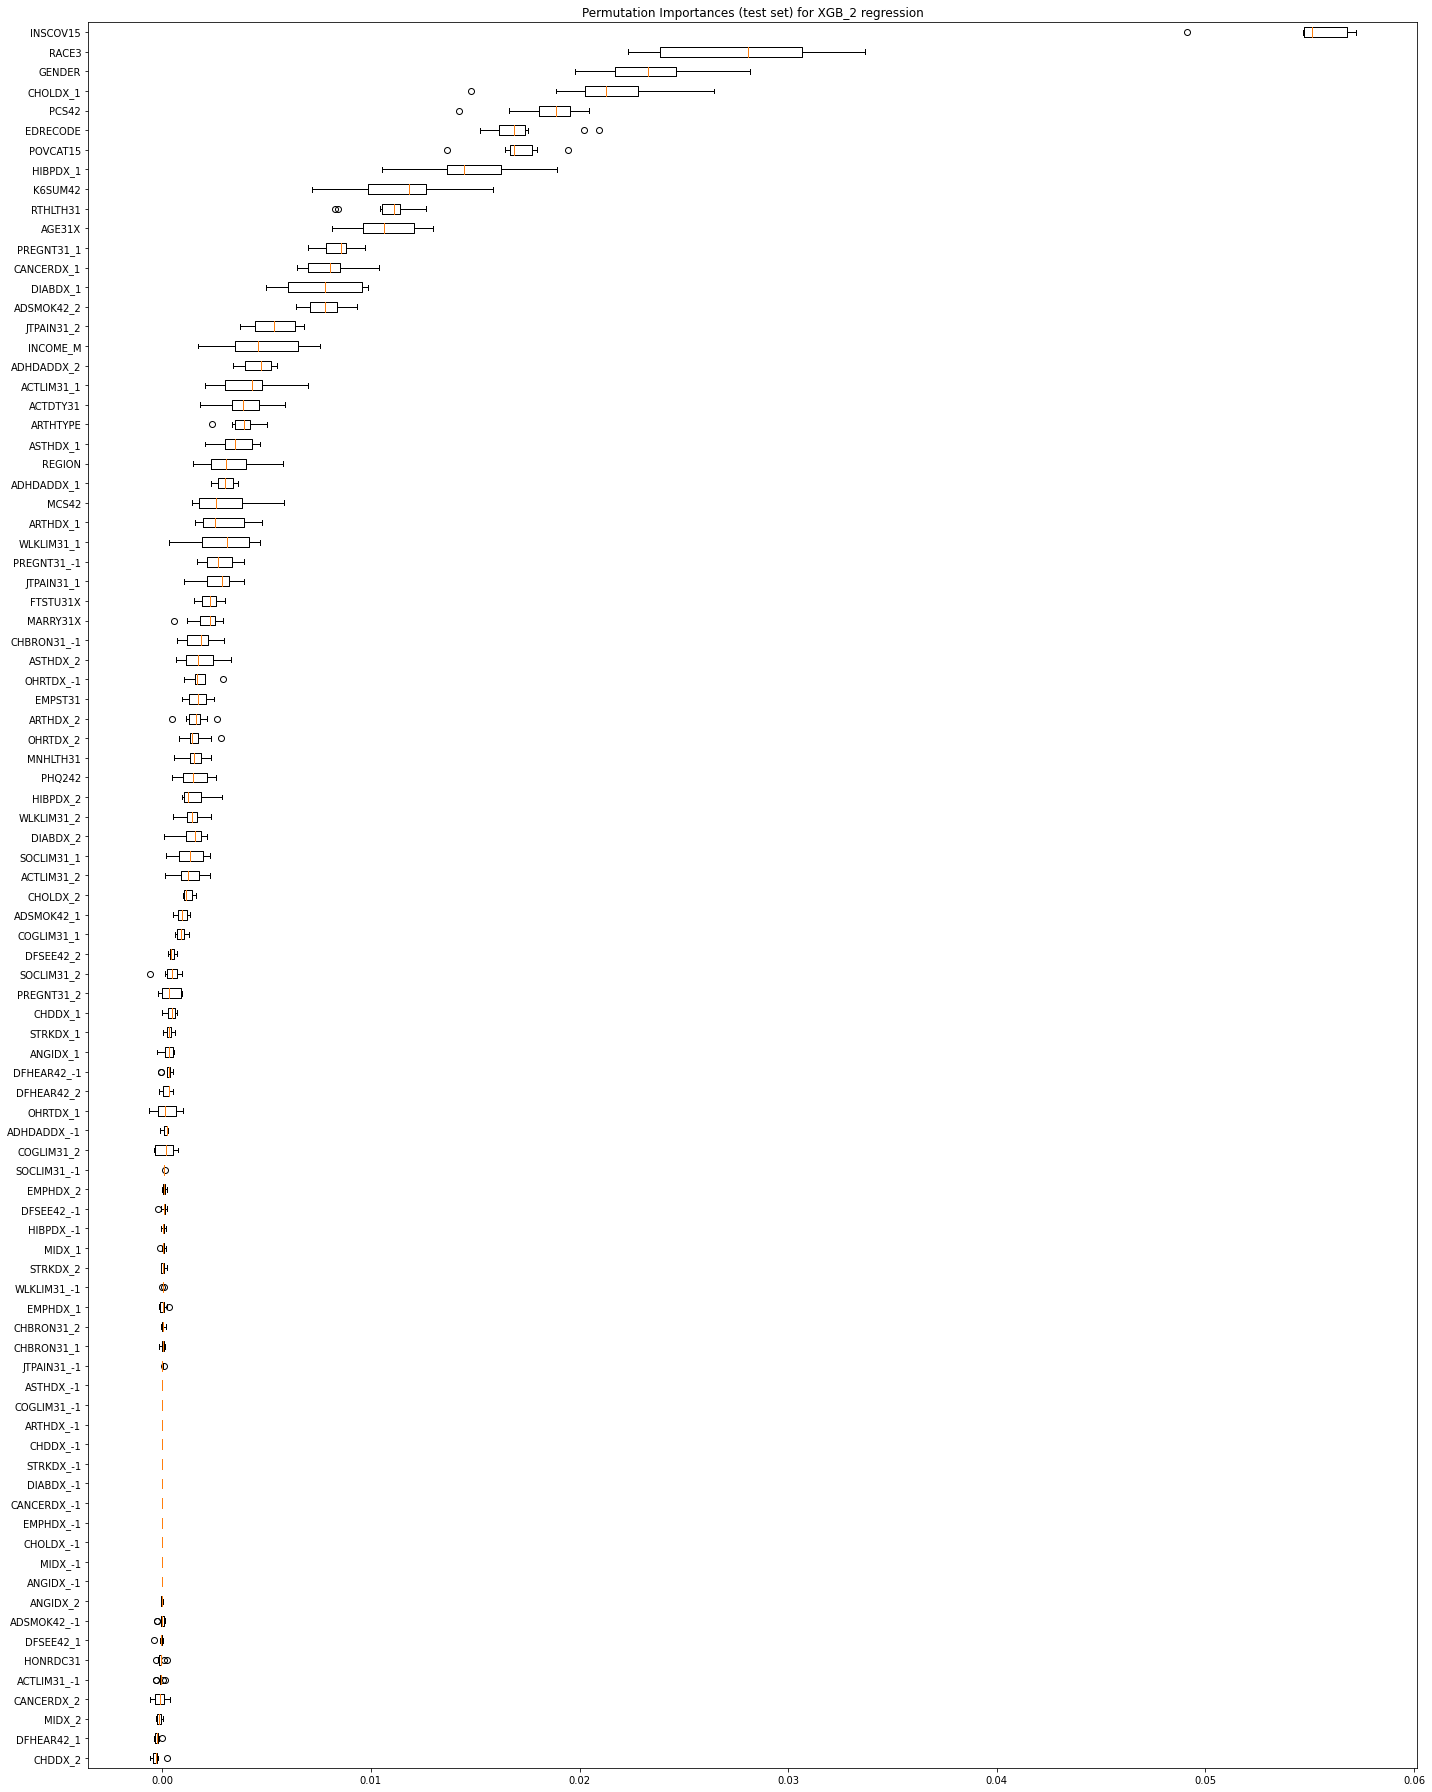

In [10]:
plot_model_permutation_feature_importance(xgb_reg_2, x_test_2, y_test, "XGB_2 regression")

## 3) Model XGB  with additional data transformations
### Model's additional data transformations: one hot encoding, minmax scaling, addition of a column (# of tested positive)

In [11]:
x_train_3 = x_train_2.copy()
x_test_3 = x_test_2.copy()

# One extra column - how many times tested positive 
cat_inx = x_train_3.nunique()[x_train_3.nunique() == 3 ].index.tolist()
cat_inx.remove('INSCOV15')
fn = lambda row: sum([row[n]  for n in cat_inx if row[n] == 1])
col_train = x_train_3.apply(fn, axis=1)
col_test = x_test_3.apply(fn, axis=1)
x_train_3 = x_train_3.assign(POSVT=col_train.values)
x_test_3 = x_test_3.assign(POSVT=col_test.values)

In [12]:
d = 6
n = 60
feature_names = list(x_train)
xgb_reg_3 = xgb.XGBRegressor(objective ='reg:squarederror',
                          colsample_bytree = 0.4,
                          learning_rate = 0.2,
                          max_depth = d,
                          alpha = 15,
                          n_estimators = n,
                          feature_names=feature_names
                          )
xgb_reg_3.fit(x_train_3, y_train)
predictions_train = xgb_reg_3.predict(x_train_3)
predictions_test = xgb_reg_3.predict(x_test_3)
xgb_3_res = get_model_results(f"XGB  ", predictions_train, y_train, predictions_test, y_test, True)

XGB   results:
training rmse: 2.001923531369142
training r2: 0.47439446455704903
training mae: 1.4835221534450043
test rmse: 2.1641499330064535
test r2: 0.37769987437695984
test mae: 1.6054573155491896



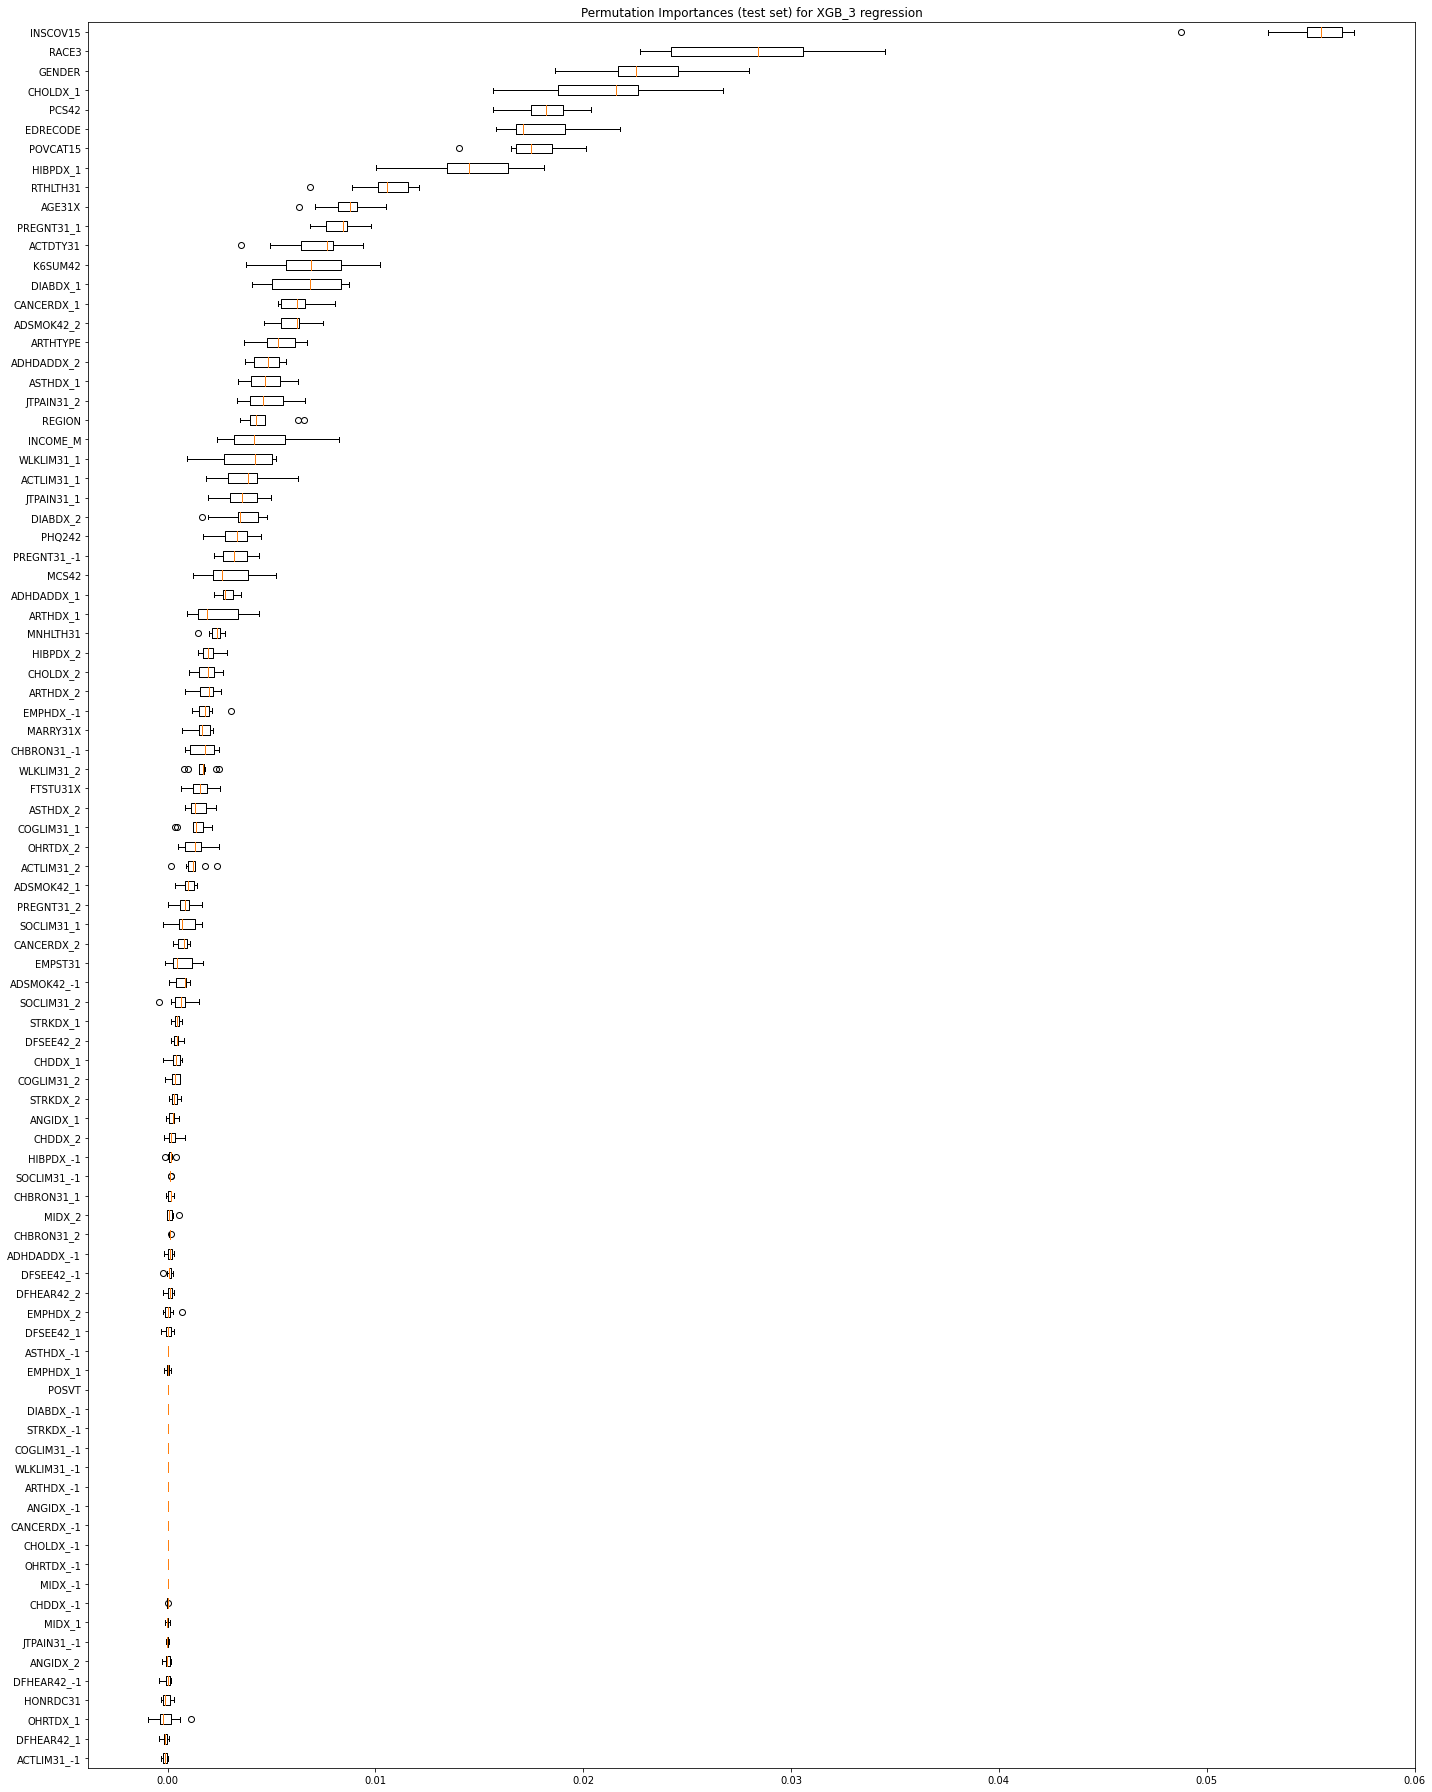

In [13]:
plot_model_permutation_feature_importance(xgb_reg_3, x_test_3, y_test, "XGB_3 regression")

## 4) Model Random Forrest 

In [14]:
rf_1 = RandomForestRegressor(random_state=21, bootstrap=False, max_depth=70,
                             max_features=3, min_samples_leaf=3, min_samples_split=8,
                             n_estimators=500)
rf_1.fit(y=np.ravel(y_train, order='C'), X=x_train)
pred_rf_test = rf_1.predict(x_test) 
pred_rf_train = rf_1.predict(x_train)
rf_1_res = get_model_results(f"Random Forrest  ", pred_rf_train, y_train, pred_rf_test, y_test, True)

Random Forrest   results:
training rmse: 1.7726968555568756
training r2: 0.5878703026796824
training mae: 1.3053567063441656
test rmse: 2.2009505281433546
test r2: 0.35635594953464256
test mae: 1.6319088794583885



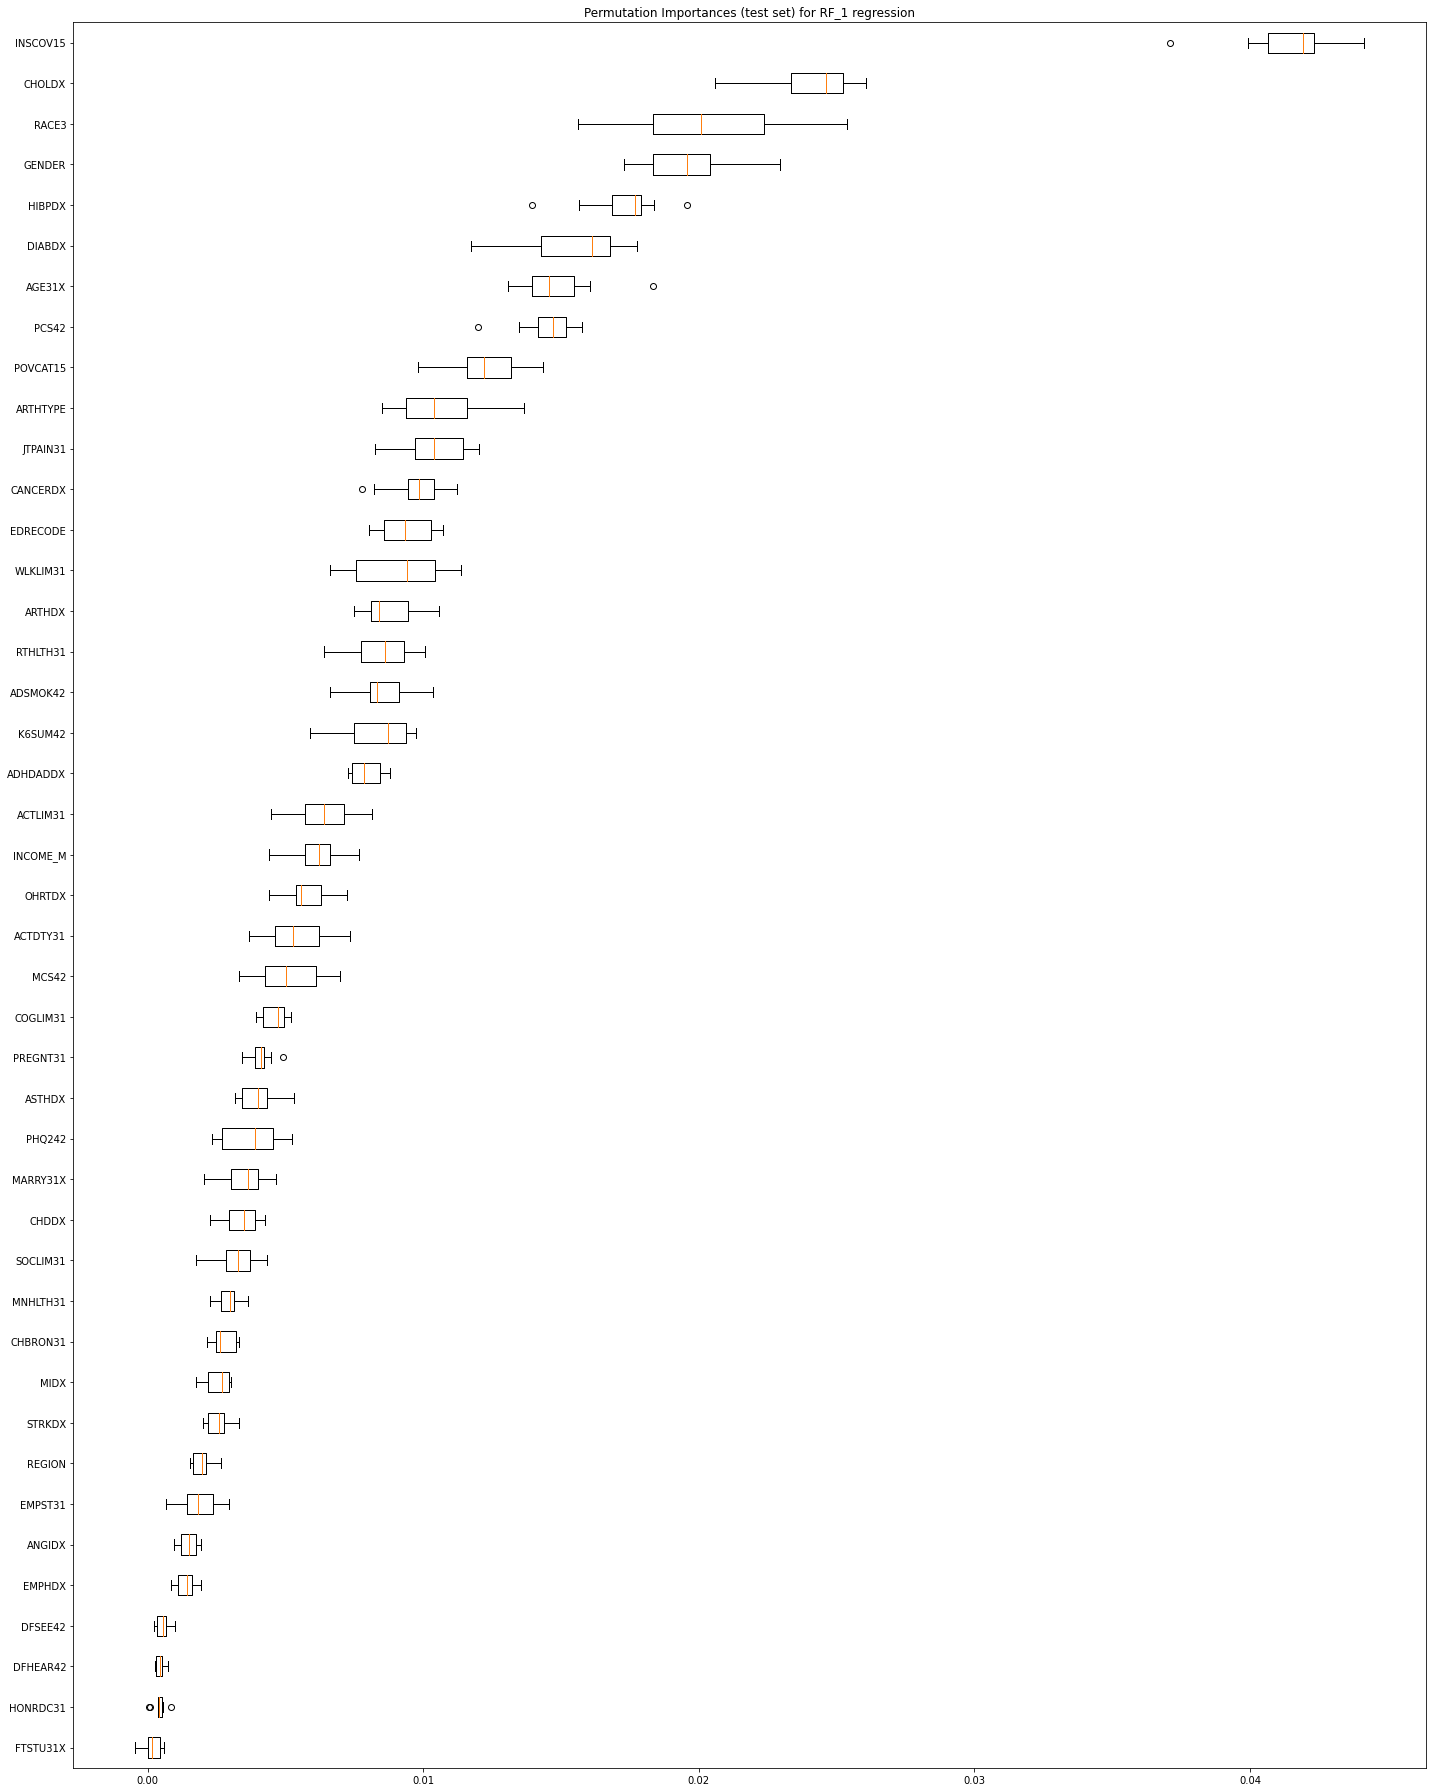

In [15]:
plot_model_permutation_feature_importance(rf_1, x_test, y_test, "RF_1 regression")

## 5) Model Random Forrest 
### Model's additional data transformations: one extra column

In [16]:
x_train_5 = x_train.copy()
x_test_5 = x_test.copy()

# One extra column - how many times tested positive 
cat_inx = x_train_5.nunique()[x_train_5.nunique() == 3 ].index.tolist()
cat_inx.remove('INSCOV15')
fn = lambda row: sum([row[n]  for n in cat_inx if row[n] == 1])
col_train = x_train_5.apply(fn, axis=1)
col_test = x_test_5.apply(fn, axis=1)
x_train_5 = x_train_5.assign(POSVT=col_train.values)
x_test_5 = x_test_5.assign(POSVT=col_test.values)

In [17]:
rf_2 = RandomForestRegressor(random_state=21, bootstrap=False, max_depth=70,
                             max_features=3, min_samples_leaf=3, min_samples_split=8,
                             n_estimators=500)
rf_2.fit(y=np.ravel(y_train, order='C'), X=x_train_5)
pred_rf_test = rf_2.predict(x_test_5) 
pred_rf_train = rf_2.predict(x_train_5)
rf_2_res = get_model_results(f"Random Forrest  ", pred_rf_train, y_train, pred_rf_test, y_test, True)

Random Forrest   results:
training rmse: 1.7406618476467186
training r2: 0.6026311840255166
training mae: 1.282522908124817
test rmse: 2.188991026223282
test r2: 0.363331797851958
test mae: 1.627112620552408



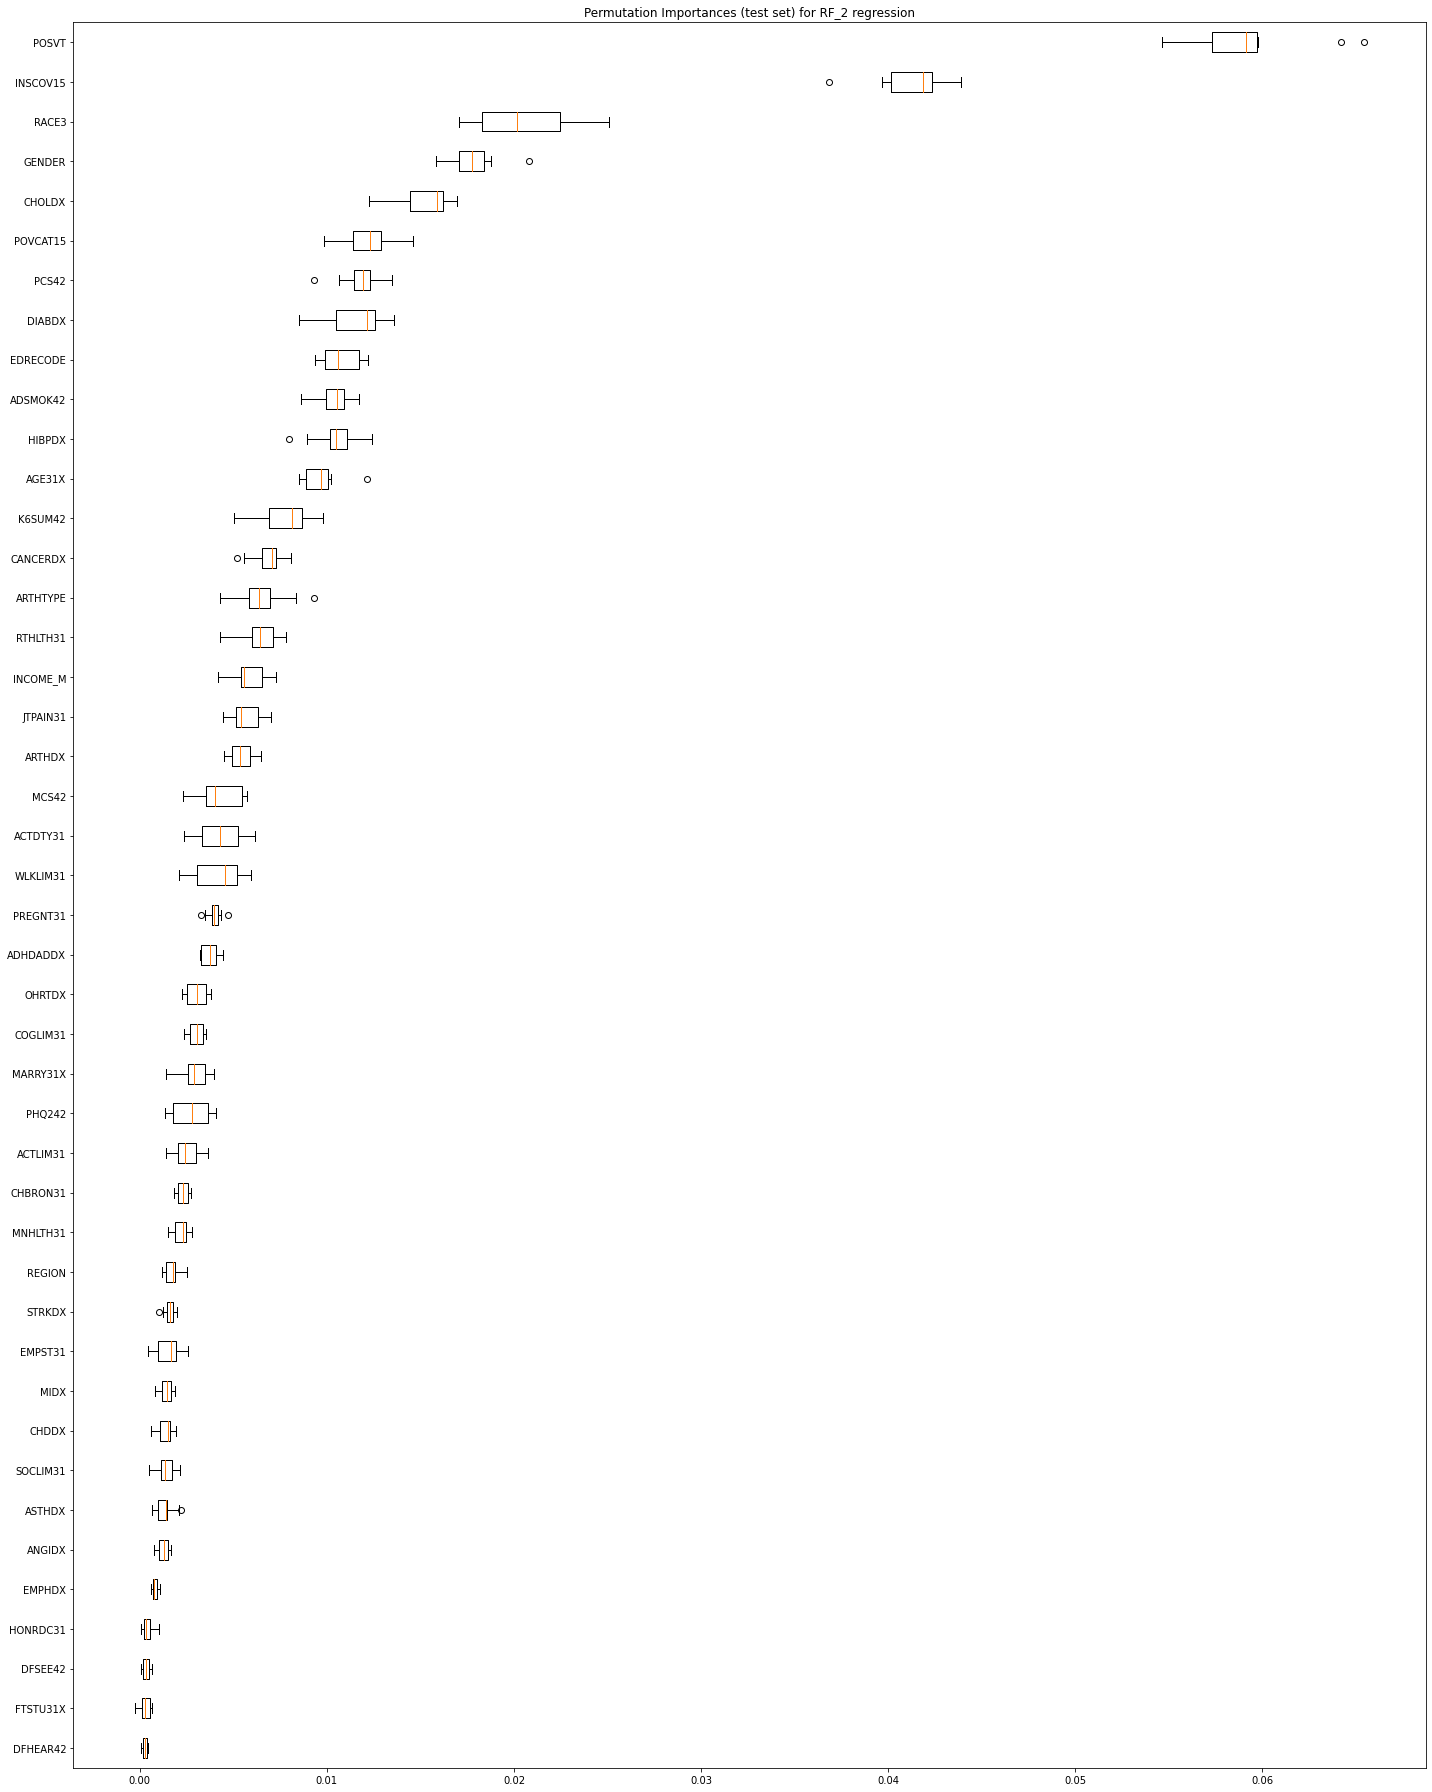

In [18]:
plot_model_permutation_feature_importance(rf_2, x_test_5, y_test, "RF_2 regression")

## 6) Linear model 
### Model's additional data transformations: addition of a column (# of tested positive), minmax scaling

In [19]:
x_train_6 = x_train.copy()
x_test_6 = x_test.copy()

# Minmax scaling
inx_to_minmax_scale = ['RTHLTH31', 'MNHLTH31', 'POVCAT15'] 

scaler = MinMaxScaler()

for col in inx_to_minmax_scale:
    val = x_train_6[col].values 
    x_train_6[col] = scaler.fit_transform(val.reshape(-1,1)) 
    val = x_test_6[col].values 
    x_test_6[col] = scaler.fit_transform(val.reshape(-1,1)) 

# One extra column - how many times tested positive 
cat_inx = x_train_6.nunique()[x_train_6.nunique() == 3 ].index.tolist()
cat_inx.remove('INSCOV15')
fn = lambda row: sum([row[n]  for n in cat_inx if row[n] == 1])
col_train = x_train_6.apply(fn, axis=1)
col_test = x_test_6.apply(fn, axis=1)
x_train_6 = x_train_6.assign(POSVT=col_train.values)
x_test_6 = x_test_6.assign(POSVT=col_test.values)

In [20]:
param = [{'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20, 30, 40, 50, 100, 150, 200]}]
ridge = Ridge()

ridge_reg = GridSearchCV(ridge, param_grid=param, cv=4)
ridge_reg.fit(x_train_6, y_train)
pred_rr_test = ridge_reg.predict(x_test_6)
pred_rr_train = ridge_reg.predict(x_train_6)

ridge_res = get_model_results("Ridge Regression", pred_rr_train, y_train, pred_rr_test, y_test, True)


Ridge Regression results:
training rmse: 2.266885671580016
training r2: 0.3260554024765099
training mae: 1.717582420692549
test rmse: 2.2507713632601125
test r2: 0.32688702912191125
test mae: 1.6984020041883288



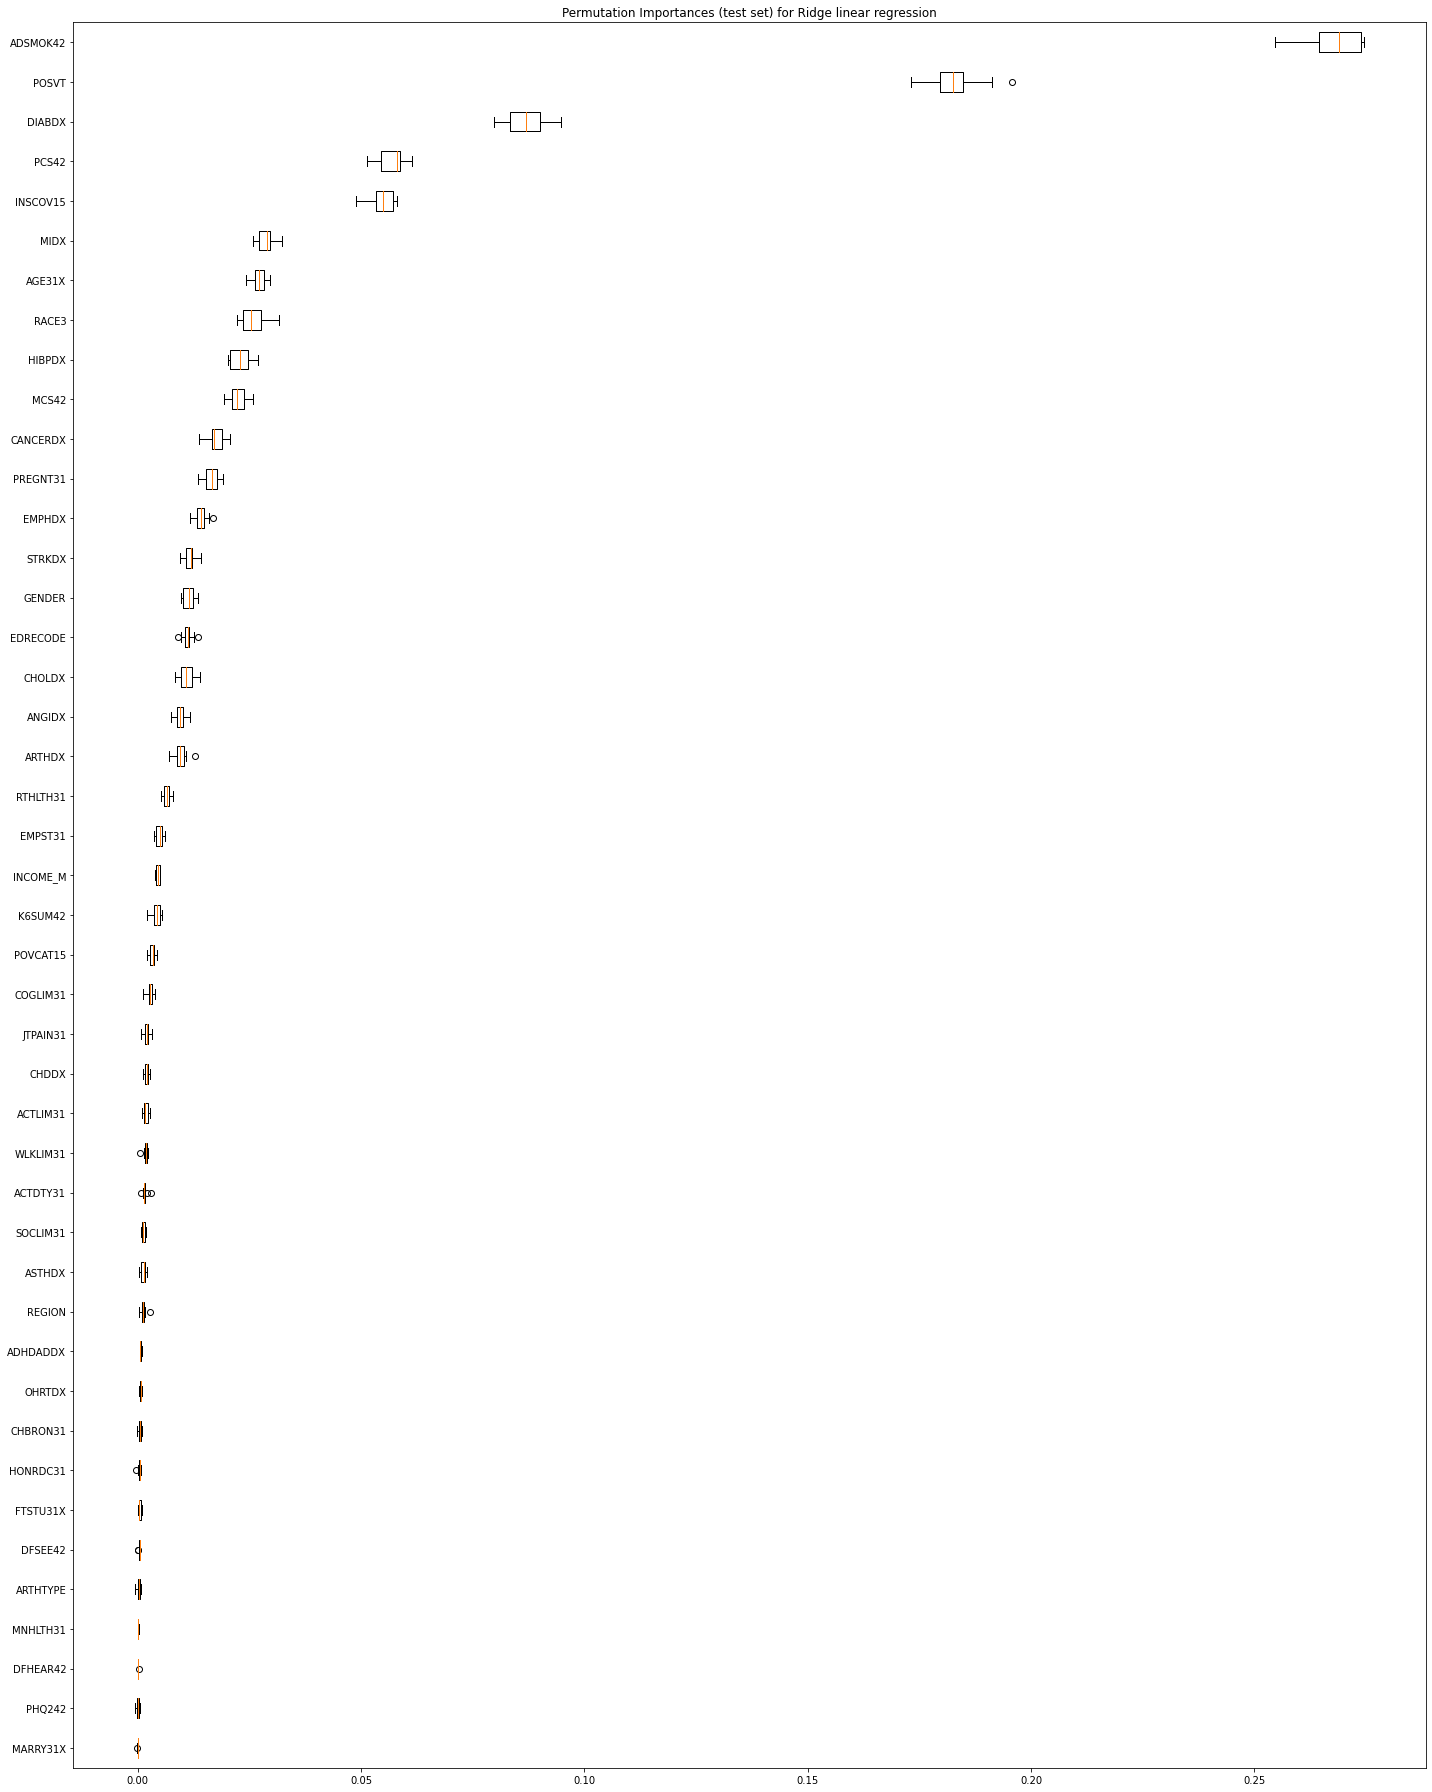

In [21]:
plot_model_permutation_feature_importance(ridge_reg, x_test_6, y_test, "Ridge linear regression")

## The results 

### Comments and results:
Medical Expenditure Panel Survey  (MEPS) data set about medical health and its costs. The explainable variable is called HEALTHEXP and describes the cost of the patient’s health expenses. 
For this homework, data primarily was only divided into the training and test data set. Due the long tail of the HEALTHEXP it was transformed with the logarithm of a base 3 (easier to explain than with the natural logarithm).
Following models were trained:
1) XGB
2) XGB with one hot encoding and minmax scaling
3) XGB with one hot encoding, minmax scaling and creation of additional column
4) Random Forest
5) Random Forest with the additional column
6) Linear model with minmax scaling and creation of additional column

One hot encoding concerned the categorical variables : 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON31', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN31', 'ARTHDX', 'ASTHDX', 'ADHDADDX', 'PREGNT31', 'WLKLIM31', 'ACTLIM31', 'SOCLIM31', 'COGLIM31', 'DFHEAR42', 'DFSEE42', 'ADSMOK42'. This variables describe if the patient has given symptom/disease/condition. Each of them has three possibles values -1 (inapplicable), 1 (yes) or 2 (no). 

Minmax scaling concerned the numerical variables: 'RTHLTH31', 'MNHLTH31', 'POVCAT15'.   RTHLTH31 encodes the perceived health status. MNHLTH31  describes the perceived mental health status. For both of  variables scale goes from -1  to 5, where 5 is poor.   POVCAT15 encoded the income. Scale goes from  1 to 5, where 1 is poor and 5 is high income. 

Additional column creation is the transformations that creates an additional column which counts how many times given patient was tested positive for any  symptom/disease/condition. The column was called  ‘POSVT’. 

Regarding XGB typ models (1,2 and 3) the test results (r^2) were the best for model 3 (test r2: 0.377, mae: 1.605,  rmse: 2.164).  Model 2 had slightly worse results than model 3 (test r2: 0.376, mae: 1.61, rmse: 2.166). Model 1 had the worst results (test r2: 0.367, mae: 1.622, rmse: 2.181). Model 2 and 3 have really close results. 
3 most important features:
- model 1: INSCOV15, DIABDX, RACE3
- model 2: INSCOV15, RACE3, GENDER
- model 3: INSCOV15, RACE3, GENDER
Model 2 and 3 had 7 the most important features of the same variables in the same order. 
It interesting to notice that distributions of each of the variables differs in each model, especially in the most important one (INSCOV15). 
INSCOV15 is categorical variables which tells if patient has a insurance (private or public).
DIABDX is also a categorical variable which tells if patients has been diagnosed with diabetes.   
RACE3 describes the race (0 or 1). 

Regarding the random forest models (4 and 5), model 5 had better scores () than model 4 (test r^2: 0.356,  mae: 1.631, rmse: 2.2).
3 most important features:
- model 4:  INSCOV15, CHOLDX, RACE3
- model 5:  POSVT, INSCOV15, RACE3
Models  has in common two the most important variables. 

## The results 

### Comments and results:
Medical Expenditure Panel Survey  (MEPS) data set about medical health and its costs. There are 45 variables. The explainable variable is called HEALTHEXP and describes the cost of the patient’s health expenses. 
For this homework, data primarily was only divided into the training and test data set. Due the long tail of the HEALTHEXP it was transformed with the logarithm of a base 3 (easier to explain than with the natural logarithm).
Following models were trained:
1) XGB
2) XGB with one hot encoding and minmax scaling
3) XGB with one hot encoding, minmax scaling and creation of additional column
4) Random Forest
5) Random Forest with the additional column
6) Linear model with minmax scaling and creation of additional column

One hot encoding concerned the categorical variables : 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON31', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN31', 'ARTHDX', 'ASTHDX', 'ADHDADDX', 'PREGNT31', 'WLKLIM31', 'ACTLIM31', 'SOCLIM31', 'COGLIM31', 'DFHEAR42', 'DFSEE42', 'ADSMOK42'. This variables describe if the patient has given symptom/disease/condition. Each of them has three possibles values -1 (inapplicable), 1 (yes) or 2 (no). 

Minmax scaling concerned the numerical variables: 'RTHLTH31', 'MNHLTH31', 'POVCAT15'.   RTHLTH31 encodes the perceived health status. MNHLTH31  describes the perceived mental health status. For both of  variables scale goes from -1  to 5, where 5 is poor.   POVCAT15 encoded the income. Scale goes from  1 to 5, where 1 is poor and 5 is high income. 

Additional column creation is the transformations that creates an additional column which counts how many times given patient was tested positive for any  symptom/disease/condition. The column was called  ‘POSVT’. 

Regarding XGB typ models (1,2 and 3), model 2 and 3 have really close results. The test results (r^2) were the best for model 3 (test r2: 0.377, mae: 1.605,  rmse: 2.164).  Model 2 had slightly worse results  (r^2) than model 3 (test r2: 0.376, mae: 1.61, rmse: 2.166). Model 1 had the worst results (test r2: 0.367, mae: 1.622, rmse: 2.181). 
3 most important features:
- model 1: INSCOV15, DIABDX, RACE3
- model 2: INSCOV15, RACE3, GENDER
- model 3: INSCOV15, RACE3, GENDER

Model 2 and 3 had 7 the most important features of the same variables in the same order. 
It interesting to notice that distributions of each of the variables differs in each model, especially in the most important one (INSCOV15). 
INSCOV15 is categorical variables which tells if patient has a insurance (private, public or none).
DIABDX is also a categorical variable which tells if patients has been diagnosed with diabetes.   
RACE3 describes the race (0 or 1). 

Regarding the random forest models (4 and 5), model 5 had better scores (test r^2: 0.363, mae: 1.627, rmse: 2.188) than model 4 (test r^2: 0.356,  mae: 1.631, rmse: 2.2).
3 most important features:
- model 4:  INSCOV15, CHOLDX, RACE3
- model 5:  POSVT, INSCOV15, RACE3

Random Forest models as XGB had INSCOV15 as one of the most important variables. Also the distribution of this variables differs. 
POSVT is a variable that was created and counts the number of patients positive results.  It is the most important for random forest model 5 but for model 3 (XGB) this variable is 20th from the bottom (so completely opposite). 

Last of investigated models was a linear model. Test results were worse than for any other model (test r^2: 0.326, mae: 1.698, rmse: 2.25). 
3 most important features: 
- ADSMOKE42
- POSVT
- DIABDX

As in the random forest model, POSVT is rather important. 
ADSMOKE42 describe if patients smokes. For the linear model this variable turn out to be the most important while for the rest it was not (for all models ADSMOKE42 was not in the first 10 most important variables). 
As in the model 1 DIABDX had significant importance for the model. 

